<a href="https://colab.research.google.com/github/judelo/algosto/blob/master/python/TP_gradient_stochastique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TP Descente de gradient stochastique

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from TP_gradient_stochastique import *

## Régression en faible dimension

On se propose d'illustrer le principe du gradient stochastique sur un exemple très simple de régression linéaire en une dimension. On observe des couples $(x_i,y_i)$ réalisations de $(X,Y)$ avec $X$ qui suit une loi uniforme sur $[0,1]$ et   
$$Y = aX+b+\epsilon$$ 
où $\epsilon \sim \mathcal{N}(0,1)$. 
On commence par tirer aléatoirement les observations $(x_i,y_i)$.

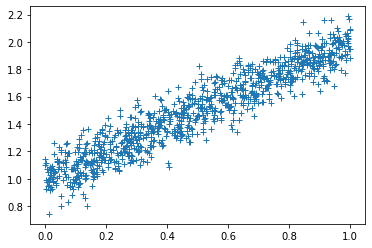

In [3]:
M = int(1e3)
x = np.random.rand(M,1)
sigma = 0.1
y = x + 1 + sigma*np.random.randn(x.shape[0],x.shape[1])
plt.plot(x,y,'+')

### Descente de gradient

On suppose maintenant qu'on observe les $(x_i,y_i)$ mais qu'on ne connaît pas $a$ et $b$. Pour déterminer $a$ et $b$, on propose de minimiser 
$$f(a,b) = \frac 1 N \sum_{i=1}^N (y_i - a x_i -b)^2$$

La minimisation a évidemment une solution explicite, mais le but ici est d'illustrer l'algorithme de gradient stochastique.  A titre de référence, on commence donc par effectuer une descente de gradient classique (déterministe) sur $f$, dont les étapes sont : 
$$a^{(k+1)} = a^{(k)} - \rho\frac 2 N \sum_{i=1}^N x_i ( a^{(k)} x_i +b^{(k)} - y_i)$$
$$b^{(k+1)} = b^{(k)} - \rho\frac 2 N \sum_{i=1}^N ( a^{(k)} x_i +b^{(k)}-y_i)$$
avec $\rho$ le pas de la descente.
Comme $f$ est strictement convexe, on sait qu'une descente de gradient classique avec un pas choisi suffisamment petit (inférieur à $\frac 2 L$ avec $L$ la constante de Lipschitz du gradient de $f$) va converger vers la solution (voir par exemple [ici](http://users.ece.utexas.edu/~cmcaram/EE381V_2012F/Lecture_4_Scribe_Notes.final.pdf)).


In [4]:
f = lambda a,b : 1/(x.shape[0])*np.sum((a*x+b-y)**2)

On se propose de faire $30$ expériences pour tester différentes initialisations.

In [5]:
L    = 30                                           # nombre d'experiences
a0,b0 = 1+np.random.randn(L,),1+np.random.randn(L,) # initialisations
niter = int(1e3)                                    # nombre d'iterations de la descente
rho   = 0.1                                         # pas

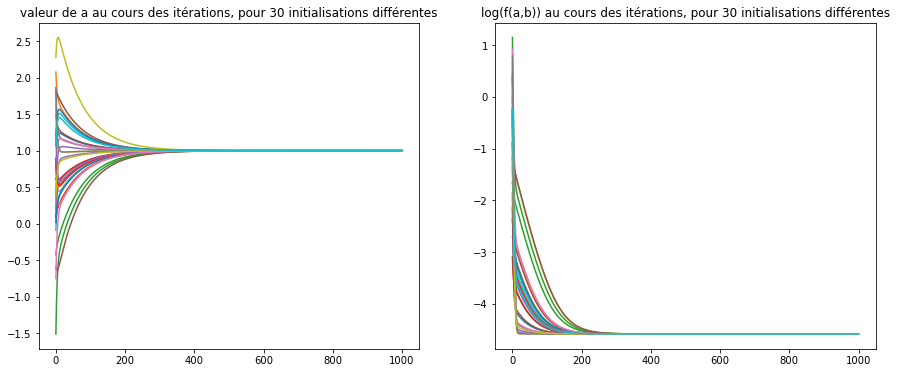

In [6]:
plt.figure(figsize=(15,6))
t_a = np.zeros((niter,))
cout = np.zeros((niter,))
axes  = plt.subplot(1, 2, 1)
axes2 = plt.subplot(1, 2, 2)

# Descente de gradient classique
for l in range(L):
    a,b = a0[l],b0[l]
    for k in range(niter):
        t_a[k] = a 
        dfa, dfb = 2/M*np.sum(x*(a*x+b-y)), 2/M*np.sum((a*x+b-y))
        a = a - rho*dfa
        b = b - rho*dfb
        cout[k] = f(a,b)
    axes.plot(t_a)
    axes.set_title('valeur de a au cours des itérations, pour 30 initialisations différentes')
    axes2.plot(np.log(cout))
    axes2.set_title('log(f(a,b)) au cours des itérations, pour 30 initialisations différentes')
plt.show()          

### Descente de gradient stochastique

On se propose maintenant de faire la même expérience avec une descente de gradient stochastique. A chaque pas on ne tient compte que d'un couple $(x_i,y_i)$. A l'étape $k$, on tire donc un $i_k$ uniformément dans $\{1,\dots,M\}$ et on calcule
$$a^{(k+1)} = a^{(k)} - 2\rho_k x_{i_k} ( a^{(k)} x_{i_k} +b^{(k)}-y_{i_k})$$
$$b^{(k+1)} = b^{(k)} - 2\rho_k ( a^{(k)} x_{i_k} +b^{(k)}-y_{i_k})$$
Les résulats de convergence pour le gradient stochastique nécessitent généralement que la suite de pas positifs $(\rho_k)_k$ soit telle que la série $\sum_k\rho_k$ diverge et que la série $\sum_k\rho_k^2$ converge. Il est ainsi classique de choisir 
$$\rho_k = \frac{\alpha}{\beta k +1}.$$
Dans ce TP on choisira généralement $\beta = 0.01$. On prend ici $\alpha = 1$.

<p><font color="red"> Implémentez un gradient stochastique pour calculer le minimum de la fonction f précédente. </font></p>

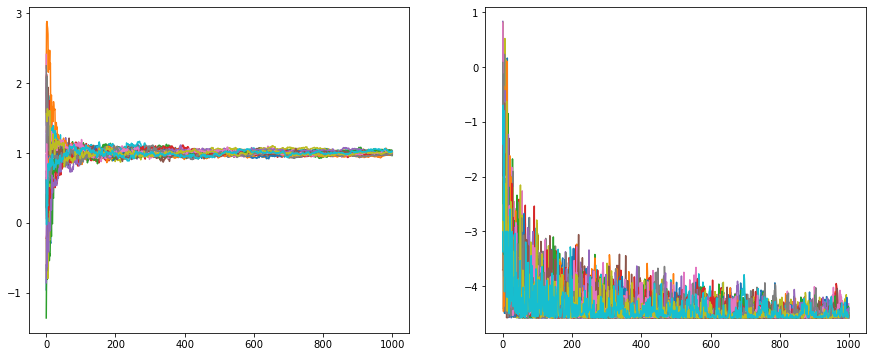

In [7]:
exo1(x,y)

## SGD pour la classification 

Afin de tester la descente de gradient stochastique en plus grande dimension, on s'intéresse à un problème de classification supervisée. 
Etant donné une base d'apprentissage constituée de $M$ vecteurs d'observations $\{x^{(m)}\}_{m=1,\dots,M}$ vivant dans $\mathbb{R}^p$ et de leurs classes $\{y^{(m)}\}_{m=1,\dots,M}$ (on suppose ici qu'il y a deux classes $C_0$ et $C_1$, donc que les $y^{(m)}$ appartiennent à $\{0,1\}$), le but est de pouvoir classer n'importe  quel nouveau vecteur de données dans une des deux classes $\mathcal C_k$, $k=0,1$.  


Par souci de simplicité, on se restreint à des modèles linéaires pour la classification, qui peuvent s'écrire de manière générale sous la forme 
$$y(x;w) = f\left( \sum_{i=0}^{p-1} w_ix_i + w_{p}\right)$$ 
avec $x = (x_0,\dots,x_{p-1})$
et $f$ est une *fonction d'activation* non linéaire fixée qui sera seuillée pour trouver les classes. Pour simplifier les notations, on écrit plutôt $x = (x_0,\dots,x_{p-1},1)$ et $w = (w_0,\dots,w_{p})$, et le modèle devient
$$y(x;w) = f\left( w^T x \right).$$

On choisit ici pour $f$ la fonction logistique $$f(x) = \frac 1 {1+e^{-x}}.$$ 

Pour une donnée $x^{(m)}$, $f(w^T x^{(m)})$ représentera la probabilité que cette donnée soit dans la classe $C_1$. 
Pour trouver les paramètres $w=(w_0,\dots,w_p)$ permettant de faire coller le  modèle $y(x;w)$ le mieux possible avec les données observées $(x^{(1)},y^{(1)}),\dots  (x^{(m)},y^{(m)})$, on propose de maximiser la vraisemblance des données
$$\prod_{m=1}^M f\left( w^T x^{(m)} \right)^{y^{(m)}}(1-f\left( w^T x^{(m)} \right))^{(1-y^{(m)})}.$$



donc de minimiser la fonction de perte
$$\mathcal{L}(w) = -\frac 1 M \sum_{m=1}^M y^{(m)}\log f\left( w^T x^{(m)} \right) + (1-y^{(m)})\log (1-f\left( w^T x^{(m)} \right)).$$

1. Calculer le gradient de $\mathcal{L}$ par rapport à $w$. 
2. Proposer et implémenter un algorithme de gradient classique et un algorithme de gradient stochastique pour résoudre numériquement le problème de minimisation 
$$\min_w \mathcal{L}(w).$$

On commence par créer des données de faible dimension, que l'on crée à partir de tirages gaussiens.

In [8]:
M = 1000 # nombre d'echantillons
p = 2    # dimension
omega = np.ones((1,2))*3
n1 = int(M/2)
X = np.vstack(( np.random.randn(n1,p), np.random.randn(n1,p)+np.ones([n1,1])*omega ))
y = np.vstack(( np.ones([n1,1]), np.zeros([n1,1]) ))

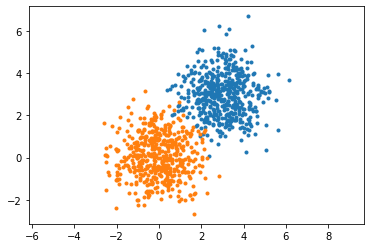

In [9]:
I = np.nonzero(y==0)[0]
J = np.nonzero(y==1)[0]
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.axis('equal');

In [10]:
# on ajoute un offset aux données pour avoir un modèle affine 
X = np.concatenate((X,np.ones((X.shape[0],1))), axis = 1)

<p><font color="red"> Implémentez un gradient stochastique pour résoudre le problème de classification précédent. Affichez la fonction de coût au cours des itérations et le résultat de classification final.</font></p>

In [11]:
w0     = np.random.randn(X.shape[1],1)
cout,w = exo2(X,y,w0,1e3,1)

In [12]:
def l(x,w):  
    return 1/(1+np.exp(-x.dot(w)))

[]

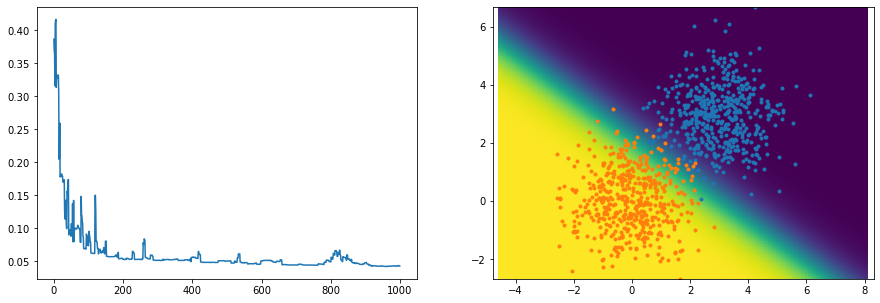

In [13]:
fig = plt.figure(figsize = (15,5) )
fig.add_subplot(121)    
plt.plot(cout)
    
n = 100
tx = np.linspace( X[:,0].min(), X[:,0].max(),num=n) 
ty = np.linspace( X[:,1].min(), X[:,1].max(),num=n) 
[B,A] = np.meshgrid( ty,tx )
G = np.vstack([A.flatten(), B.flatten()]).transpose()
Gwithoffset =  np.concatenate((G , np.ones((G.shape[0],1))),axis=1)    # on ajoute l'offset aux coordonnées
    
fig.add_subplot(122)
plt.imshow(l(Gwithoffset,w).reshape((n,n)), origin="lower",  extent=[tx.min()-2,tx.max()+2,ty.min(),ty.max()],cmap ='viridis' )
plt.axis('equal')
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.plot()

**SGA** <p><font color="red">
Faites la même expérience avec un gradient stochastique moyenné (SGA). L'idée est de calculer le nouveau vecteur wnew puis de mettre à jour w en posant : 
    
$$    w = \frac w {k+1}+w_{new}* \frac {k} {k+1}$$ </font></p>

# Classification binaire sur les (0,1) de MNIST

On va maintenant appliquer le même principe que précédemment pour de la classification binaire en grande dimension. On utilise pour cela une base d'images de chiffres manuscrits appelée MNIST. On a extrait de cette base seulement les 0 et les 1. 

In [14]:
import pandas as pd
mnist = np.array(pd.read_csv('../data/mnist_train01.csv'))
mnist = mnist[:,1:] # on enlève la première colonne qui correspond aux labels
mnist.shape

(12665, 785)

Le tableau `mnist` contient 12665 lignes et 785 colonnes. Chaque ligne correspond à un vecteur de données de taille 784 (une image 28 x 28). La première colonne correspond à la classe du vecteur. On affiche quelques-unes de ces images.

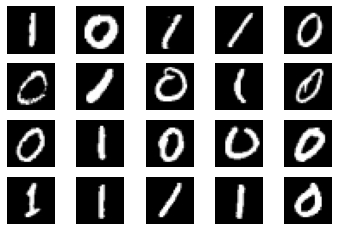

In [15]:
X = mnist[:,1:]
y = mnist[:,0].reshape(X.shape[0],1)

k = np.random.randint(0,mnist.shape[0],20)

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(X[k[i],:].reshape(28,28), cmap="gray")
    plt.axis('off')

Pour limiter le temps de calcul on va réduire la taille de ces images d'un facteur 2 dans chaque dimension pour obtenir des images de taille 14 x 14 soit des données dans un espace de dimension 196.

In [16]:
X = X.reshape(X.shape[0],28,28)
X = X[:,::2,::2]
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

On normalise l'ensemble des données et on ajoute un offset.

In [17]:
mu    = np.mean(X,0)
sigma = np.std(X,0)
X = X-mu # on centre les données
X = X/(sigma+1e-5) # on normalise les données

X = np.concatenate((X,np.ones((X.shape[0],1))), axis = 1) # on ajoute un offset aux données pour avoir un modèle affine

<p><font color="red"> Utilisez maintenant la même approche que précédemment pour classer nos données en grande dimension. Observez si votre algorithme converge en fonction de votre initialisation de w.  </font></p>

In [18]:
w0     = 0.01*np.random.randn(X.shape[1],1) # initialisation aléatoire
cout,w = exo2(X,y,w0,1e4,0.1) # descente de gradient stochastique

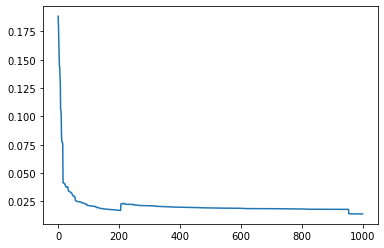

In [19]:
plt.plot(cout)

On peut calculer le taux de réussite sur la base d'apprentissage.

In [20]:
np.mean((1/(1+np.exp(-X.dot(w)))>0.5)*1==y)

0.9967627319384129

<p><font color="red"> Calculez maintenant le taux de réussite sur la base de test `mnist_test01.csv`. Quel taux obtenez-vous ? N'oubliez pas de centrer et normaliser les données de test</font></p>

In [21]:
#lecture des données de test
mnist_test = np.array(pd.read_csv('../data/mnist_test01.csv'))
mnist_test = mnist_test[:,1:]
X_test = mnist_test[:,1:]
y_test = mnist_test[:,0].reshape(X_test.shape[0],1)
# sous-échantillonnage (on ne garde que la moitié des pixels dans chaque dimension, on retransforme donc les données en images)
X_test = X_test.reshape(X_test.shape[0],28,28)
X_test = X_test[:,::2,::2]
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
# centrage et normalisation
X_test = X_test-np.mean(X_test,0)
X_test = X_test/(np.std(X_test,0)+1e-5)
# ajout de l'offset
X_test = np.concatenate((X_test,np.ones((X_test.shape[0],1))), axis = 1)
# calcul de la précision
np.mean((1/(1+np.exp(-X_test.dot(w)))>0.5)*1==y_test)

0.9985815602836879